Config loaded successfully.
Models directory set to: c:\Users\Rayyan Khan\Desktop\ORBML2\models
Loading data with features from: ..\data/processed/features_and_labels.parquet
Data with features loaded successfully.
Shape: (3249025, 70)
Checking for required regime features: ['Volatility_20_lag1', 'ATR_14_lag1']
Required regime features found.
Splitting data for training (using data up to 2020-12-31)...
Training data shape: (1877734, 70)
Training data range: 2015-01-02 08:46:00 to 2020-12-31 22:00:00
Training regime model with 3 regimes using features: ['Volatility_20_lag1', 'ATR_14_lag1']
Model will be saved to: c:\Users\Rayyan Khan\Desktop\ORBML2\models\regime_model.joblib
Scaler will be saved to: c:\Users\Rayyan Khan\Desktop\ORBML2\models\regime_scaler.joblib
Starting regime model training using features: ['Volatility_20_lag1', 'ATR_14_lag1']
Regime model saved to: c:\Users\Rayyan Khan\Desktop\ORBML2\models\regime_model.joblib
Scaler saved to: c:\Users\Rayyan Khan\Desktop\ORBML2\mode

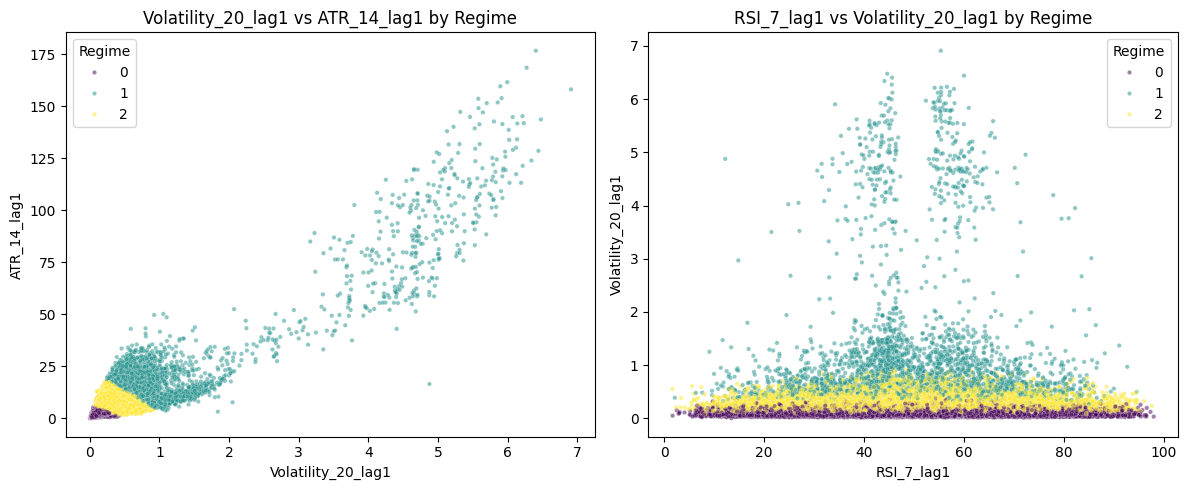


Data with features and regimes saved successfully to: ..\data/processed/features_and_labels.parquet


In [1]:
# %% [markdown]
# # 3. Regime Detection
#
# **Purpose:** Train an unsupervised model (K-Means) to identify market regimes based on selected features. Add the regime labels to the dataset.

# %%
import pandas as pd
import numpy as np
import yaml
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom functions
import sys
# Add src directory to path for importing modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from regime_model import train_regime_model, predict_regime # Import relevant functions

# Set display options
pd.set_option('display.max_rows', 100)

# %% [markdown]
# ## Load Configuration

# %%
CONFIG_PATH = '../config/config.yaml'
try:
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    print("Config loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Config file not found at {CONFIG_PATH}")
    config = None
except Exception as e:
    print(f"ERROR loading config: {e}")
    config = None

if config is None:
    raise ValueError("Failed to load configuration.")

# Define paths
PROCESSED_DIR = os.path.join('..', config['data_paths']['processed_dir'])
# Correctly join path for MODELS_DIR relative to the notebook's parent directory
MODELS_DIR = os.path.abspath(os.path.join('..', config['data_paths']['models_dir']))
FEATURES_FILE = os.path.join(PROCESSED_DIR, config['processed_files']['features_labels']) # Input and output file

# Model parameters
REGIME_PARAMS = config['regime_model_params']
N_REGIMES = REGIME_PARAMS['n_regimes']
# Ensure feature names match EXACTLY what's in config and generated by feature_engineering.py
REGIME_FEATURES = REGIME_PARAMS['features'] # e.g., ['Volatility_20_lag1', 'ATR_14_lag1']

# Data split dates
TRAIN_END_DATE = config['data_split']['train_end']

# Create models directory if it doesn't exist (using the absolute path)
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"Models directory set to: {MODELS_DIR}")


# %% [markdown]
# ## Load Data with Features

# %%
print(f"Loading data with features from: {FEATURES_FILE}")
try:
    features_df = pd.read_parquet(FEATURES_FILE)
    print("Data with features loaded successfully.")
    print(f"Shape: {features_df.shape}")

    # Ensure index is datetime
    if not pd.api.types.is_datetime64_any_dtype(features_df.index):
         features_df.index = pd.to_datetime(features_df.index)
    features_df.sort_index(inplace=True)

    # Check if regime features exist
    print(f"Checking for required regime features: {REGIME_FEATURES}")
    missing_cols = [f for f in REGIME_FEATURES if f not in features_df.columns]
    if missing_cols:
        print(f"Available columns: {features_df.columns.tolist()}")
        raise ValueError(f"Missing required features for regime detection: {missing_cols}")
    print("Required regime features found.")

except FileNotFoundError:
    print(f"ERROR: Features file not found at {FEATURES_FILE}. Run Notebook 02 first.")
    features_df = None
except Exception as e:
    print(f"ERROR loading features data: {e}")
    features_df = None

# %% [markdown]
# ## Split Data for Training
# We train the regime model only on the designated training period to avoid lookahead bias.

# %%
if features_df is not None:
    print(f"Splitting data for training (using data up to {TRAIN_END_DATE})...")
    train_df = features_df[:TRAIN_END_DATE].copy() # Includes data up to the end date
    print(f"Training data shape: {train_df.shape}")

    if train_df.empty:
        print("ERROR: No training data available for the specified period.")
        train_df = None
    else:
        print(f"Training data range: {train_df.index.min()} to {train_df.index.max()}")


else:
    train_df = None

# %% [markdown]
# ## Train Regime Model (K-Means)
# Train the K-Means model using the specified features from the training data. The function also saves the trained model and scaler.

# %%
# Initialize variables to store results from training
regime_model = None
regime_scaler = None
train_df_with_regime = None # Not strictly needed later, but returned by function

if train_df is not None:
    print(f"Training regime model with {N_REGIMES} regimes using features: {REGIME_FEATURES}")
    try:
        # --- Define full save paths using config and absolute MODELS_DIR ---
        model_filename = config['model_files']['regime_model']
        scaler_filename = config['model_files']['regime_scaler']
        model_path = os.path.join(MODELS_DIR, model_filename)
        scaler_path = os.path.join(MODELS_DIR, scaler_filename)
        print(f"Model will be saved to: {model_path}")
        print(f"Scaler will be saved to: {scaler_path}")
        # -------------------------------------------------------------

        # --- Call train_regime_model with save paths ---
        # Pass the training dataframe and the full save paths
        # The function now handles saving internally
        train_df_with_regime, regime_model, regime_scaler = train_regime_model(
            features_df=train_df,           # Pass only the training part
            n_regimes=N_REGIMES,
            features=REGIME_FEATURES,
            model_save_path=model_path,     # Pass the model save path
            scaler_save_path=scaler_path    # Pass the scaler save path
        )
        # ------------------------------------------

        # Check if training was successful
        if regime_model is not None and regime_scaler is not None:
             print("Regime model training step completed successfully (model/scaler should be saved).")
             # Optional: check the returned dataframe head if needed
             # if train_df_with_regime is not None:
             #      print("Head of training data with regimes:")
             #      print(train_df_with_regime[['Regime'] + REGIME_FEATURES].head())
        else:
             print("ERROR: Regime model training function did not return a valid model/scaler. Check function logs.")
             # Ensure variables are None if training failed
             regime_model = None
             regime_scaler = None

        # Manually inspect the printed cluster centers (output from train_regime_model)
        # Use this analysis to update regime_map in config.yaml later
        print("\n---> ACTION: Review the 'Regime Cluster Centers' above to understand regimes.")
        print("---> Update 'position_sizing_params.regime_multipliers' in config.yaml based on this analysis.")


    except Exception as e:
        print(f"ERROR during the regime model training cell execution: {e}")
        import traceback
        traceback.print_exc()
        # Ensure variables are None on error
        regime_model = None
        regime_scaler = None

else:
    print("Skipping regime model training as training data is not available.")
    # Ensure variables are None if skipped
    regime_model = None
    regime_scaler = None


# %% [markdown]
# ## Predict Regimes for Entire Dataset
# Load the saved model and scaler (if training didn't fail), then predict the regime for all data points (train, validation, test).

# %%
# We need to reload the model/scaler in case the kernel restarts or if training happened in a different session.
# Also check if training actually succeeded in the previous cell.

# Try loading the saved model and scaler
loaded_regime_model = None
loaded_regime_scaler = None
if regime_model is None or regime_scaler is None: # If training failed or was skipped
     print("Training failed/skipped in previous cell. Attempting to load model/scaler from file...")
     try:
          model_path = os.path.join(MODELS_DIR, config['model_files']['regime_model'])
          scaler_path = os.path.join(MODELS_DIR, config['model_files']['regime_scaler'])
          if os.path.exists(model_path) and os.path.exists(scaler_path):
               loaded_regime_model = joblib.load(model_path)
               loaded_regime_scaler = joblib.load(scaler_path)
               print("Successfully loaded pre-existing regime model and scaler from file.")
          else:
               print("Could not find saved model/scaler files. Cannot proceed with prediction.")
     except Exception as e:
          print(f"Error loading model/scaler from file: {e}")
else:
     # If training succeeded in the previous cell, use those objects directly
     print("Using regime model and scaler objects from successful training run.")
     loaded_regime_model = regime_model
     loaded_regime_scaler = regime_scaler


# Proceed only if model and scaler are available (either from training or loading)
if features_df is not None and loaded_regime_model is not None and loaded_regime_scaler is not None:
    print("\nPredicting regimes for the entire dataset...")

    # Select the features needed for prediction
    X_full = features_df[REGIME_FEATURES].copy()

    # Handle potential NaNs before scaling/prediction (using median from training if available)
    # For simplicity here, we'll just fill with 0 if NaNs exist, but using training median is better
    nan_rows = X_full.isnull().any(axis=1)
    if nan_rows.any():
        print(f"Warning: Found {nan_rows.sum()} rows with NaNs in features for prediction. Filling with 0.")
        X_full.fillna(0, inplace=True) # Or use forward fill, median calculated on train_df etc.

    # Scale the features using the loaded/trained scaler
    try:
        X_full_scaled = loaded_regime_scaler.transform(X_full)

        # Predict regimes using the loaded/trained model
        predicted_regimes = loaded_regime_model.predict(X_full_scaled)

        # Add the 'Regime' column to the main features DataFrame
        features_df['Regime'] = predicted_regimes
        print("Regime labels added to the DataFrame.")
        print("\nRegime distribution (Full Dataset):")
        print(features_df['Regime'].value_counts(normalize=True).sort_index())

    except Exception as e:
        print(f"ERROR during regime prediction or scaling: {e}")
        if 'Regime' in features_df.columns: # Remove column if partially added before error
             del features_df['Regime']


else:
    print("\nSkipping regime prediction for the full dataset (model/scaler/data unavailable).")


# %% [markdown]
# ## Visualize Regimes (Example)
# Plot features colored by the predicted regime to see if the separation makes sense.

# %%
if features_df is not None and 'Regime' in features_df.columns:
    print("\nVisualizing features by predicted regime (using a sample)...")
    # Sample data to make plotting faster
    sample_df = features_df.sample(min(50000, len(features_df)), random_state=42) if len(features_df) > 50000 else features_df

    plt.figure(figsize=(12, 5))

    # Example: Plot Volatility vs ATR colored by Regime
    # Ensure the correct column names from REGIME_FEATURES are used
    vol_col = REGIME_FEATURES[0] if len(REGIME_FEATURES) > 0 else None # Assuming Volatility is first
    atr_col = REGIME_FEATURES[1] if len(REGIME_FEATURES) > 1 else None # Assuming ATR is second

    plt.subplot(1, 2, 1)
    if vol_col and atr_col and vol_col in sample_df.columns and atr_col in sample_df.columns:
        sns.scatterplot(data=sample_df, x=vol_col, y=atr_col, hue='Regime', palette='viridis', s=10, alpha=0.5)
        plt.title(f'{vol_col} vs {atr_col} by Regime')
    else:
        print(f"Skipping Vol/ATR plot - features {vol_col} or {atr_col} missing")

    # Example: Plot another feature vs Volatility colored by Regime (e.g., RSI)
    # Use the correct RSI column name from feature_engineering
    rsi_col_name = f"RSI_{config['feature_params']['rsi_period']}_lag1"

    plt.subplot(1, 2, 2)
    if vol_col and rsi_col_name in sample_df.columns and vol_col in sample_df.columns:
        sns.scatterplot(data=sample_df, x=rsi_col_name, y=vol_col, hue='Regime', palette='viridis', s=10, alpha=0.5)
        plt.title(f'{rsi_col_name} vs {vol_col} by Regime')
    else:
         print(f"Skipping RSI/Vol plot - features {rsi_col_name} or {vol_col} missing")

    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping regime visualization (data or Regime column unavailable).")


# %% [markdown]
# ## Save Data with Features and Regimes
# Overwrite the features file with the data now including the 'Regime' column.

# %%
if features_df is not None and 'Regime' in features_df.columns:
    try:
        # Overwriting the FEATURES_FILE defined earlier
        features_df.to_parquet(FEATURES_FILE)
        print(f"\nData with features and regimes saved successfully to: {FEATURES_FILE}")
    except Exception as e:
        print(f"ERROR saving data with features and regimes: {e}")
else:
    print("\nSkipping saving data with regimes (data or Regime column unavailable).")


# %% [markdown]
# ---
# End of Notebook 03
# ---